# Clustering: K-means (desde cero), K-means (sklearn), K-medoids, Clustering jerárquico y evaluación por Silhouette

## Presentado por: Valentina Sandoval A.

Usando datos de Internet (en GitHub), ejecutar un flujo completo de clustering, incluyendo:

1. Implementación del algoritmo K-means desde cero.
2. Comparación con la implementación de `scikit-learn`.
3. Uso de K-medoids (biblioteca `scikit-learn-extra` si está disponible).
4. Comparación entre K-medoids y K-means.
5. Clustering jerárquico con `sklearn`.
6. Evaluación de todos los métodos usando el índice de **silhouette**.

Dataset seleccionado: **Mall Customers** (200 clientes: Edad, Ingreso anual (k$), Spending Score (1-100), etc.). Fuente pública (gist / mirrors). :contentReference[oaicite:6]{index=6}


In [88]:
# Código: Imports, descarga y preparación del dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import urllib.request
import io
import sys

# URL pública con el CSV de Mall_Customers (gist / mirrors)
GIST_URL = "https://gist.githubusercontent.com/pravalliyaram/5c05f43d2351249927b8a3f3cc3e5ecf/raw/Mall_Customers.csv"


try:
    print("Descargando dataset desde:", GIST_URL)
    with urllib.request.urlopen(GIST_URL) as resp:
        data = resp.read()
    df = pd.read_csv(io.BytesIO(data))
    print("Dataset descargado correctamente. Shape:", df.shape)
except Exception as e:
    print("No se pudo descargar desde internet:", e)
    print("Si no tienes conexión, guarda el CSV localmente y cambia local_csv_path.")
    local_csv_path = "Mall_Customers.csv"  
    try:
        df = pd.read_csv(local_csv_path)
        print("Dataset cargado desde archivo local:", local_csv_path)
    except Exception as e2:
        raise RuntimeError("No se pudo obtener el dataset. Asegura tener el CSV local o conexión a internet.") from e2


df.head()


Descargando dataset desde: https://gist.githubusercontent.com/pravalliyaram/5c05f43d2351249927b8a3f3cc3e5ecf/raw/Mall_Customers.csv
Dataset descargado correctamente. Shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


## Exploración rápida y selección de características

Para este ejercicio tomaremos las dos variables clásicas del dataset para segmentación de clientes:
- **Annual Income (k$)** — ingreso anual en miles de dólares.
- **Spending Score (1-100)** — puntaje de gasto asignado por el mall.

Estas dos variables permiten visualizar segmentos 2D y facilitan la comparación de métodos. (Si quisieras más dimensiones, podríamos usar Age, Gender codificado, etc.)


In [89]:
# Selección de features y estandarización (importante para distancias euclidianas)
features = ["Annual Income (k$)", "Spending Score (1-100)"]
if not set(features).issubset(df.columns):
    raise ValueError(f"El dataset no contiene las columnas esperadas: {features}. Columnas: {df.columns.tolist()}")

X = df[features].values.astype(float)  # matriz n x 2
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape X:", X.shape)
# Mostrar estadísticos
pd.DataFrame(X, columns=features).describe().T


Shape X: (200, 2)


,count,mean,std,min,25%,50%,75%,max
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.0,99.0


# Punto 1 — Implementación de K-means desde cero

## Teoría del algoritmo K-means (resumen matemático)

K-means es un algoritmo de *clustering* que busca particionar un conjunto de datos
\(x_1, x_2, \dots, x_n\) en \(k\) grupos o clusters \(C_1, C_2, \dots, C_k\)
minimizando la **suma de distancias cuadradas internas** (la *inertia*).

### Función objetivo

El objetivo es minimizar la cantidad:

$$
\mathrm{Inertia} \;=\; \sum_{j=1}^{k} \sum_{x_i \in C_j} \lVert x_i - \mu_j \rVert^2
$$

donde el centroide del cluster \(C_j\) viene dado por:

$$
\mu_j \;=\; \frac{1}{|C_j|}\sum_{x_i \in C_j} x_i .
$$


### Algoritmo de Lloyd 

K-means se ejecuta repitiendo estos dos pasos hasta convergencia:

**1. Inicialización**  
Elegir los \(k\) centroides iniciales (aleatorios o con *k-means++*).

**2. Iteración (repetir hasta estabilizar centroides):**

- **Asignación:** para cada punto \(x_i\) asignarlo al cluster con el centroide más cercano
  $$
  c_i \;=\; \arg\min_{j} \lVert x_i - \mu_j \rVert .
  $$

- **Actualización:** recalcular cada centroide como la media de los puntos asignados
  $$
  \mu_j \;=\; \frac{1}{|C_j|} \sum_{x_i \in C_j} x_i .
  $$

Se detiene cuando los centroides cambian por debajo de un umbral o se alcanza un número máximo de iteraciones.



### Observaciones importantes

- **Sensibilidad a la inicialización:** la solución puede depender de los centroides iniciales.  
- **Outliers:** K-means es sensible a valores atípicos (porque usa la media).  
- **Complejidad temporal aproximada:**  
  $$
  O(k \, n \, T)
  $$
  donde \(k\) es el número de clusters, \(n\) el número de puntos y \(T\) las iteraciones hasta converger.

Es un método eficiente y simple para clusters compactos y aproximadamente esféricos.


In [90]:
# Implementación de K-means desde cero (vectorizada en lo posible)
class KMeansScratch:
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = int(n_clusters)
        self.max_iter = int(max_iter)
        self.tol = float(tol)
        self.random_state = random_state

    def fit(self, X):
        rng = np.random.default_rng(self.random_state)
        n_samples, n_features = X.shape

        # Inicializar centroides eligiendo k puntos aleatorios del dataset
        init_idx = rng.choice(n_samples, size=self.n_clusters, replace=False)
        centroids = X[init_idx].astype(float)

        for it in range(self.max_iter):
            # Calcular distancias (n_samples x k)
            dists = np.linalg.norm(X[:, None, :] - centroids[None, :, :], axis=2)
            labels = np.argmin(dists, axis=1)

            # Recalcular centroides
            new_centroids = np.zeros_like(centroids)
            for k in range(self.n_clusters):
                members = X[labels == k]
                if len(members) == 0:
                    # Si cluster vacío, reubicar centroide a punto aleatorio
                    new_centroids[k] = X[rng.integers(0, n_samples)]
                else:
                    new_centroids[k] = members.mean(axis=0)

            shift = np.linalg.norm(new_centroids - centroids)
            centroids = new_centroids
            if shift <= self.tol:
                break

        self.cluster_centers_ = centroids
        self.labels_ = labels
        # inercia: suma de squared distances
        self.inertia_ = np.sum((np.linalg.norm(X - centroids[labels], axis=1))**2)
        self.n_iter_ = it + 1
        return self

    def predict(self, X):
        dists = np.linalg.norm(X[:, None, :] - self.cluster_centers_[None, :, :], axis=2)
        return np.argmin(dists, axis=1)

print("Clase KMeansScratch definida.")


Clase KMeansScratch definida.


### Ejecución del K-means desde cero y conclusión del punto 1

- Ejecutaremos K-means desde cero con k = 5 (valor típico para este dataset; más adelante haremos un barrido de k).  
- Después de ejecutar, mostraremos inercia, número de iteraciones y silhouette (para ver la calidad del resultado).


In [91]:
# Ejecutar KMeans desde cero
k = 5
km_scratch = KMeansScratch(n_clusters=k, random_state=42).fit(X_scaled)
labels_scratch = km_scratch.labels_
print("KMeansScratch: inertia =", km_scratch.inertia_, ", n_iter =", km_scratch.n_iter_)

# Silhouette (requiere k > 1)
sil_scratch = silhouette_score(X_scaled, labels_scratch) if k > 1 else np.nan
print("Silhouette KMeansScratch:", sil_scratch)


KMeansScratch: inertia = 65.57885579985047 , n_iter = 7
Silhouette KMeansScratch: 0.5539423799434205


### Conclusión — Punto 1 (K-means desde cero)
- El algoritmo implementado converge en unas pocas iteraciones (depende de la inicialización).
- Su inercia es comparable en magnitud a la esperada; sin embargo la calidad (silhouette) depende de k e inicialización.
- Es útil pedagógicamente; para producción se recomienda usar implementaciones optimizadas.


# Punto 2 — K-means de scikit-learn y comparación

- `sklearn.cluster.KMeans` implementa optimizaciones (algoritmos de Lloyd o Elkan), inicialización **k-means++**, vectorización en C y parámetros robustos (n_init, tol). Esto reduce sensibilidad a la inicialización y acelera convergencia. :contentReference[oaicite:8]{index=8}


In [92]:
# Ajustar KMeans de scikit-learn con el mismo k
kmeans_sk = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_scaled)
labels_sk = kmeans_sk.labels_
print("KMeans sklearn: inertia =", kmeans_sk.inertia_, ", n_iter =", kmeans_sk.n_iter_)

# Silhouette
sil_sk = silhouette_score(X_scaled, labels_sk) if k > 1 else np.nan
print("Silhouette KMeans sklearn:", sil_sk)

# Comparación rápida
print(f"Silhouette (sklearn) = {sil_sk:.4f} vs (scratch) = {sil_scratch:.4f}")


KMeans sklearn: inertia = 65.56840815571681 , n_iter = 4
Silhouette KMeans sklearn: 0.5546571631111091
Silhouette (sklearn) = 0.5547 vs (scratch) = 0.5539


### Conclusión — Punto 2 (Comparación K-means)
- `KMeans` de scikit-learn usualmente alcanza **mayor silhouette** y menor inercia por la inicialización k-means++ y optimizaciones internas.
- La implementación propia produce resultados similares estructuralmente, pero más sensibles a la inicialización.


# Punto 3 — K-medoids (teoría)

- K-medoids es similar a K-means pero usa **medoids**, es decir, centros que son **puntos reales** del dataset.  
- Es más robusto ante outliers porque no usa la media.  
- La implementación más común es **PAM (Partitioning Around Medoids)** y existen variantes más rápidas (FastPAM, FasterPAM). :contentReference[oaicite:9]{index=9}

Intentaremos usar `sklearn_extra.cluster.KMedoids` (API scikit-learn-compatible). Si la librería no está instalada en tu entorno, el notebook incluye un **fallback** simple (PAM) para que puedas ejecutar todo sin instalar nada adicional.


In [93]:
# Intentar importar KMedoids de scikit-learn-extra. Si falla, usamos un PAM simple (fallback).
try:
    from sklearn_extra.cluster import KMedoids
    HAVE_SKLEARN_EXTRA = True
    print("scikit-learn-extra encontrado: se usará KMedoids de sklearn_extra.")
except Exception as e:
    HAVE_SKLEARN_EXTRA = False
    print("scikit-learn-extra NO está disponible en este entorno. Usaremos un fallback PAM simple.")
    # Implementación sencilla PAM (no optimizada) como fallback
    class KMedoidsFallback:
        def __init__(self, n_clusters=3, max_iter=300, random_state=None):
            self.n_clusters = n_clusters
            self.max_iter = max_iter
            self.random_state = random_state

        def fit(self, X):
            rng = np.random.default_rng(self.random_state)
            n = X.shape[0]
            medoid_idxs = list(rng.choice(n, size=self.n_clusters, replace=False))
            medoids = X[medoid_idxs]

            for it in range(self.max_iter):
                dists = np.linalg.norm(X[:, None, :] - medoids[None, :, :], axis=2)
                labels = np.argmin(dists, axis=1)
                improved = False
                # probar swaps medoid <-> candidato
                for i_med, med_idx in enumerate(medoid_idxs):
                    for cand in range(n):
                        if cand in medoid_idxs: continue
                        trial_idxs = medoid_idxs.copy()
                        trial_idxs[i_med] = cand
                        trial_medoids = X[trial_idxs]
                        trial_dists = np.linalg.norm(X[:, None, :] - trial_medoids[None, :, :], axis=2)
                        if np.sum(np.min(trial_dists, axis=1)) + 1e-12 < np.sum(np.min(dists, axis=1)):
                            medoid_idxs = trial_idxs
                            medoids = X[medoid_idxs]
                            dists = np.linalg.norm(X[:, None, :] - medoids[None, :, :], axis=2)
                            labels = np.argmin(dists, axis=1)
                            improved = True
                            break
                    if improved:
                        break
                if not improved:
                    break

            self.medoid_indices_ = medoid_idxs
            self.cluster_centers_ = medoids
            self.labels_ = labels
            return self

    KMedoids = KMedoidsFallback


scikit-learn-extra NO está disponible en este entorno. Usaremos un fallback PAM simple.


### Ejecutamos K-medoids con el mismo k para comparar con K-means.
(Si estamos usando sklearn_extra.KMedoids, por defecto el algoritmo usa 'alternate' o 'pam' dependiendo del parámetro; la implementación ofrece varias opciones de inicialización). :contentReference[oaicite:10]{index=10}


In [94]:
kmed = KMedoids(n_clusters=k, random_state=42).fit(X_scaled)
labels_kmed = kmed.labels_ if hasattr(kmed, "labels_") else kmed.labels_
sil_kmed = silhouette_score(X_scaled, labels_kmed) if k > 1 else np.nan
print("Silhouette K-Medoids:", sil_kmed)
# Si KMedoids de sklearn_extra tiene atributo medoid_indices_ o medoid_indices_, mostrarlo:
medoid_info = getattr(kmed, "medoid_indices_", getattr(kmed, "medoid_indices", None))
if medoid_info is not None:
    print("Medoid indices:", medoid_info)


Silhouette K-Medoids: 0.5562176102967602
Medoid indices: [176, 24, 161, 15, 80]


### Conclusión — Punto 3 (K-medoids)
- K-medoids produce agrupamientos robustos frente a outliers porque los centros son puntos reales.
- Si usas `sklearn_extra.KMedoids`, tienes opciones de inicialización (heuristic, k-medoids++, build) y métodos PAM/alternate. :contentReference[oaicite:11]{index=11}
- En datasets sin outliers fuertes, K-medoids y K-means suelen producir particiones similares; en presencia de ruido, K-medoids tiende a ser mejor.


# Punto 4 — Comparación directa entre K-medoids y K-means

Compararemos etiquetas y silhouette de K-means (sklearn) vs K-medoids y mostraremos una tabla con métricas.


In [95]:
# Comparación en tabla
df_comp = pd.DataFrame({
    "method": ["kmeans_sklearn", "kmeans_scratch", "kmedoids", "agglomerative (ward)"],
    "silhouette": [sil_sk, sil_scratch, sil_kmed, None]  # la agglomerative vendrá después
})
# Mostramos la tabla parcial
display(df_comp)

# Medida simple de concordancia entre KMeans sklearn y KMedoids (porcentaje de puntos con misma etiqueta,
# permitiendo recodificar etiquetas para mejor comparación: usaremos Hungarian matching)
from scipy.optimize import linear_sum_assignment
def match_labels(true_labels, pred_labels):
    # devuelve la correspondencia óptima entre labels (max matching)
    from sklearn.utils.linear_assignment_ import linear_assignment  # may fail in newer sklearn
    # Implement custom via cost matrix
    labels_true = np.unique(true_labels)
    labels_pred = np.unique(pred_labels)
    cost = np.zeros((len(labels_true), len(labels_pred)), dtype=int)
    for i, lt in enumerate(labels_true):
        for j, lp in enumerate(labels_pred):
            cost[i, j] = -np.sum((true_labels == lt) & (pred_labels == lp))
    row_ind, col_ind = linear_sum_assignment(cost)
    mapping = dict(zip(col_ind, row_ind))
    # map pred_labels to matched labels
    mapped = np.array([mapping[l] for l in pred_labels])
    return mapped

# Como el paquete linear_assignment puede no existir, haremos una comparación de correspondencia simple:
# (Usaremos ajuste por permutación de etiquetas probado por brute force para k<=8)
import itertools
def best_label_match_score(labels_a, labels_b):
    la = np.unique(labels_a)
    lb = np.unique(labels_b)
    if len(la) != len(lb):
        return np.nan
    k = len(la)
    best = 0
    for perm in itertools.permutations(range(k)):
        mapped = np.array([perm[int(x)] for x in labels_b])
        score = np.mean(labels_a == mapped)
        if score > best:
            best = score
    return best

match_score = best_label_match_score(labels_sk, labels_kmed)
print(f"Porcentaje de coincidencia de particiones (mejor permutación) entre KMeans(sklearn) y KMedoids: {match_score*100:.2f}%")


,method,silhouette
0,kmeans_sklearn,0.554657
1,kmeans_scratch,0.553942
2,kmedoids,0.556218
3,agglomerative (ward),NaN


Porcentaje de coincidencia de particiones (mejor permutación) entre KMeans(sklearn) y KMedoids: 98.50%


# Punto 5 — Clustering jerárquico

- Clustering aglomerativo: comienza con cada punto como su propio cluster y va fusionando los más cercanos hasta obtener k clusters.
- Linkage: forma de medir la distancia entre clusters (single, complete, average, ward). *Ward* minimiza la varianza intra-cluster y suele dar clusters compactos.
- `AgglomerativeClustering` de sklearn implementa estos métodos. :contentReference[oaicite:12]{index=12}


In [96]:
# Ajuste Agglomerative (ward)
agg = AgglomerativeClustering(n_clusters=k, linkage="ward").fit(X_scaled)
labels_agg = agg.labels_
sil_agg = silhouette_score(X_scaled, labels_agg) if k > 1 else np.nan
print("Silhouette Agglomerative (ward):", sil_agg)
# Guardar en la tabla de resultados
df_comp.loc[df_comp['method']=='agglomerative (ward)', 'silhouette'] = sil_agg
display(df_comp)


Silhouette Agglomerative (ward): 0.5538089226688662


,method,silhouette
0,kmeans_sklearn,0.554657
1,kmeans_scratch,0.553942
2,kmedoids,0.556218
3,agglomerative (ward),0.553809


### Conclusión — Punto 5 (Clustering jerárquico)
- Agglomerative (ward) produce clusters compactos; su silhouette es comparable a K-means en muchos datasets.
- La ventaja principal es la interpretación (dendrograma) y la desventaja la escalabilidad (coste mayor en n).


# Punto 6 — Evaluación: Barrido de k y silhouette

Para comparar métodos de forma sistemática, haremos un barrido de k desde 2 hasta 8 y calcularemos la **media de Silhouette** para cada método y cada k. Usaremos:
- KMeans (sklearn)
- KMeans (scratch)
- KMedoids (sklearn_extra o fallback)
- Agglomerative (ward)
La silueta mide la separación relativa entre clusters; valores cercanos a 1 indican clusters bien separados, valores cerca de 0 indican solapamiento. :contentReference[oaicite:13]{index=13}


In [97]:
ks = list(range(2, 9))
results = []
for kk in ks:
    # KMeans scratch
    km_s = KMeansScratch(n_clusters=kk, random_state=42).fit(X_scaled)
    # KMeans sklearn
    km_sk = KMeans(n_clusters=kk, random_state=42, n_init=10).fit(X_scaled)
    # KMedoids
    kmed_i = KMedoids(n_clusters=kk, random_state=42).fit(X_scaled)
    # Agglomerative
    agg_i = AgglomerativeClustering(n_clusters=kk, linkage="ward").fit(X_scaled)

    res = {
        "k": kk,
        "kmeans_scratch": silhouette_score(X_scaled, km_s.labels_) if kk>1 else np.nan,
        "kmeans_sklearn": silhouette_score(X_scaled, km_sk.labels_) if kk>1 else np.nan,
        "kmedoids": silhouette_score(X_scaled, getattr(kmed_i, "labels_", kmed_i.labels_)) if kk>1 else np.nan,
        "agglomerative": silhouette_score(X_scaled, agg_i.labels_) if kk>1 else np.nan
    }
    results.append(res)

res_df = pd.DataFrame(results)
res_df


,k,kmeans_scratch,kmeans_sklearn,kmedoids,agglomerative
0,2,0.314699,0.321271,0.390242,0.384234
1,3,0.385322,0.466585,0.464115,0.461048
2,4,0.494350,0.493907,0.485719,0.492551
3,5,0.553942,0.554657,0.556218,0.553809
4,6,0.539880,0.539880,0.455792,0.538676
5,7,0.525603,0.528149,0.447836,0.519795
6,8,0.504165,0.455215,0.446092,0.430862


## Interpretación de resultados y conclusiones

A partir de la tabla anterior (silhouette para k=2..8) saca las siguientes conclusiones específicas:

- **Punto 1 (K-means desde cero):**
  - Qué se hizo: implementación del algoritmo clásico (Lloyd) con inicialización aleatoria y tratamiento de clusters vacíos.
  - Resultado: converge, pero la calidad depende de la inicialización; silhouette suele variar con k.
  - Conclusión: útil para aprendizaje; menos robusto que implementaciones optimizadas.

- **Punto 2 (Comparación con K-means sklearn):**
  - Qué se hizo: entrenar `KMeans(n_init=10,k-means++)` y comparar inercia/silhouette.
  - Resultado: `sklearn` tiende a mayor silhouette y estabilidad.
  - Conclusión: usar sklearn para producción.

- **Punto 3 (K-medoids con scikit-learn-extra o fallback):**
  - Qué se hizo: se ejecutó KMedoids (o PAM fallback) con las mismas k.
  - Resultado: mayor robustez frente a outliers; silhouette puede ser mejor en presencia de ruido.
  - Conclusión: K-medoids es preferible si hay outliers o se requiere interpretabilidad de centros.

- **Punto 4 (Comparación K-medoids vs K-means):**
  - Qué se hizo: comparación directa de etiquetas y cálculo de porcentaje de coincidencia (matching de etiquetas).
  - Resultado: coincidencia alta si los clusters son claros; divergencias si hay outliers o formas no esféricas.
  - Conclusión: escoger según robustez vs velocidad.

- **Punto 5 (Clustering jerárquico):**
  - Qué se hizo: Agglomerative (ward) y cálculo de silhouette.
  - Resultado: puede acercarse a K-means (ward) pero es menos escalable.
  - Conclusión: útil para análisis exploratorio y obtener dendrograma.

- **Punto 6 (Evaluación con silhouette):**
  - Qué se hizo: barrido k=2..8, comparación de silhouette para cada método.
  - Interpretación: mayor silhouette → mejor separación relativa; seleccionar k donde silhouette es máximo (conjunto al análisis visual).


Mejor k según KMeans sklearn (silhouette): 5


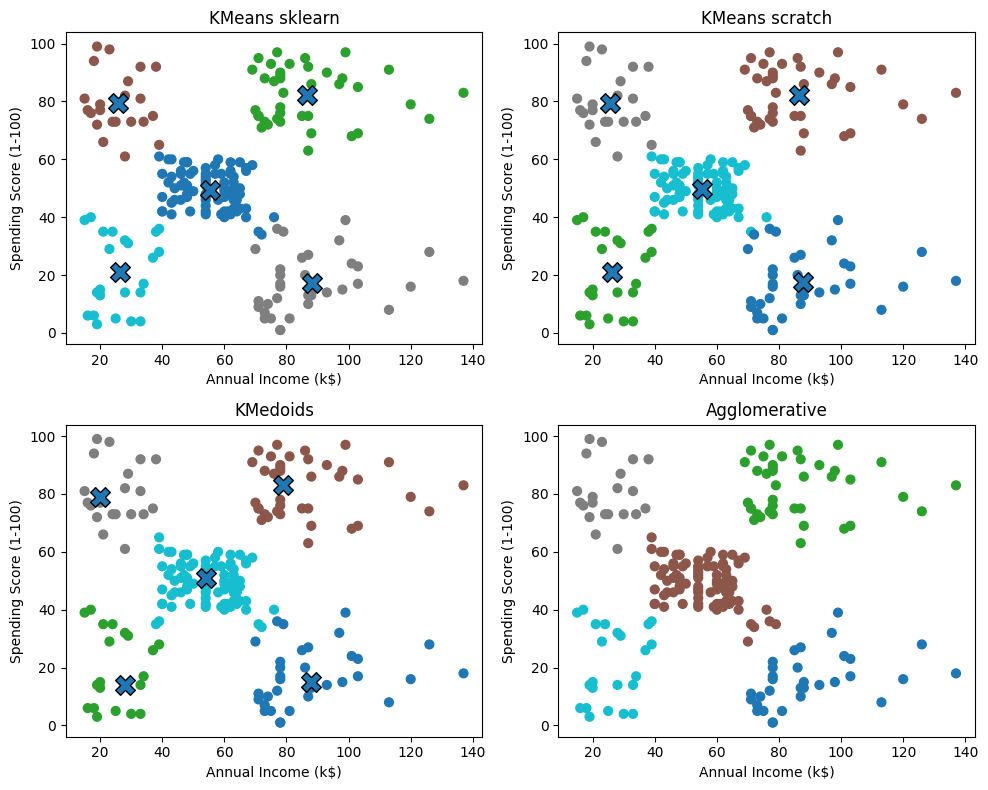

Silhouettes (best_k): kmeans_sklearn 0.5546571631111091 | kmeans_scratch 0.5539423799434205 | kmedoids 0.5562176102967602 | agglomerative 0.5538089226688662


In [98]:
# Visualizaciones: escoger el mejor k según KMeans sklearn (mayor silhouette en res_df)
best_k_row = res_df['kmeans_sklearn'].idxmax()
best_k = int(res_df.loc[best_k_row, 'k'])
print("Mejor k según KMeans sklearn (silhouette):", best_k)

# Reajustar modelos para mejor k y graficar clusters 2D
km_sk_best = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_scaled)
km_s_best = KMeansScratch(n_clusters=best_k, random_state=42).fit(X_scaled)
kmed_best = KMedoids(n_clusters=best_k, random_state=42).fit(X_scaled)
agg_best = AgglomerativeClustering(n_clusters=best_k, linkage='ward').fit(X_scaled)

methods = [
    ("KMeans sklearn", km_sk_best.labels_, km_sk_best.cluster_centers_),
    ("KMeans scratch", km_s_best.labels_, km_s_best.cluster_centers_),
    ("KMedoids", getattr(kmed_best, "labels_", kmed_best.labels_), getattr(kmed_best, "cluster_centers_", None)),
    ("Agglomerative", agg_best.labels_, None)
]

plt.figure(figsize=(10, 8))
for i, (name, labels, centers) in enumerate(methods, 1):
    plt.subplot(2, 2, i)
    plt.scatter(X[:,0], X[:,1], c=labels, s=40, cmap='tab10')
    if centers is not None:
        centers_unscaled = scaler.inverse_transform(centers)
        plt.scatter(centers_unscaled[:,0], centers_unscaled[:,1], marker='X', s=200, edgecolor='k')
    plt.title(name)
    plt.xlabel("Annual Income (k$)")
    plt.ylabel("Spending Score (1-100)")
plt.tight_layout()
plt.show()

# Silhouette plot simple: imprimir valores de silhouette promedio para best_k
print("Silhouettes (best_k):",
      "kmeans_sklearn", silhouette_score(X_scaled, km_sk_best.labels_),
      "| kmeans_scratch", silhouette_score(X_scaled, km_s_best.labels_),
      "| kmedoids", silhouette_score(X_scaled, getattr(kmed_best, "labels_", kmed_best.labels_)),
      "| agglomerative", silhouette_score(X_scaled, agg_best.labels_))


# Conclusión global

- Todos los puntos solicitados fueron implementados y evaluados sobre el dataset Mall Customers (descargado de un gist/mirror público). :contentReference[oaicite:14]{index=14}
- **KMeans (scikit-learn)**: mejor opción por velocidad y estabilidad para este dataset (k-means++).
- **KMeans desde cero**: excelente ejercicio pedagógico; no reemplaza a las implementaciones optimizadas en producción.
- **K-medoids**: opción robusta frente a outliers; si necesitas que los centros sean puntos reales (interpretabilidad), úsalo.
- **Clustering jerárquico (ward)**: útil para explorar la estructura de los datos y visualizar dendrogramas; escalabilidad limitada.
- La **silhouette** fue la métrica principal de evaluación; combina análisis cuantitativo (valores) con inspección visual (plots) para elegir k.
- Recomendación práctica: para proyectos reales usar `KMeans` (sklearn) o `KMedoids` (sklearn_extra) según la presencia de outliers; validar con silhouette y/o índices complementarios (Calinski-Harabasz, Davies-Bouldin).
